# Figure 1

## imports and utils

In [3]:
import jax.numpy as np

import jax
from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
  
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

## Setting

In [4]:
sigmaw = 1.5; sigmab = 0.1;train_points = 20;

In [5]:
import numpy
from neural_tangents import monte_carlo_kernel_fn
number_width = 10
number_sample = 6

nngp_gau_mc = numpy.zeros((number_width,number_sample,train_points,train_points))
ntk_gau_mc = numpy.zeros((number_width,number_sample,train_points,train_points))
nngp_ort_mc = numpy.zeros((number_width,number_sample,train_points,train_points))
ntk_ort_mc = numpy.zeros((number_width,number_sample,train_points,train_points))
ntk  = numpy.zeros((number_width,train_points,train_points))
nngp = numpy.zeros((number_width,train_points,train_points))

key = random.PRNGKey(10)
key, x_key, y_key = random.split(key, 3)

train_xs  = random.normal(x_key, (train_points,1024))*1.0**0.5

/home/whuang1/miniconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## ntk-parameterization Gaussian NNGP L=1

In [6]:
for nw in range(0,number_width):

    Width = 2**(nw+3);
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(Width, W_std=sigmaw, b_std=sigmab ,parameterization='ntk'),  stax.Relu(), 
        stax.Dense(Width, W_std=sigmaw, b_std=sigmab ,parameterization='ntk')              #10
    )
    
    nngp[nw] = kernel_fn(train_xs, train_xs, ('nngp')) 

    for ns in range(0,number_sample):
        sample = 2**ns
        kernel_fn_gau_mc = monte_carlo_kernel_fn(init_fn, apply_fn, 
                                  key=random.PRNGKey(1), n_samples=sample)

        nngp_gau_mc0 = kernel_fn_gau_mc(train_xs, train_xs, get=('nngp'))
    
        nngp_gau_mc[nw,ns] = nngp_gau_mc0
        #ntk_gau_mc[nw,ns] = ntk_gau_mc0.reshape(train_points,train_points)

/home/whuang1/miniconda3/lib/python3.7/site-packages/jax/lax/lax.py:4627: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


## ntk-parameterization Orthogonal NNGP L=1

In [13]:
nngp_ort_mc = numpy.zeros((number_width,number_sample,train_points,train_points))

import example.stax_orth as stax1
for nw in range(0,number_width):

    Width = 2**(nw+3);
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax1.Dense_orth(Width, W_std=sigmaw, b_std=sigmab ,parameterization='ntk'),  stax.Relu(), 
        stax1.Dense_orth(Width, W_std=sigmaw, b_std=sigmab ,parameterization='ntk')              #10
    )

    for ns in range(0,number_sample):
        sample = 2**ns
        kernel_fn_ort_mc = monte_carlo_kernel_fn(init_fn, apply_fn, 
                                  key=random.PRNGKey(1), n_samples=sample)

        nngp_ort_mc0 = kernel_fn_ort_mc(train_xs, train_xs, get=('nngp'))
    
        nngp_ort_mc[nw,ns] = nngp_ort_mc0
        #ntk_gau_mc[nw,ns] = ntk_gau_mc0.reshape(train_points,train_points)

## ntk-parameterization Gaussian NTK L=1

In [14]:
for nw in range(0,number_width):

    Width = 2**(nw+3);
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(Width, W_std=sigmaw, b_std=sigmab ,parameterization='ntk'),  stax.Relu(), 
        stax.Dense(1, W_std=sigmaw, b_std=sigmab ,parameterization='ntk')              
    )
    
    ntk[nw] = kernel_fn(train_xs, train_xs, ('ntk')) 

    for ns in range(0,number_sample):
        sample = 2**ns
        kernel_fn_gau_mc = monte_carlo_kernel_fn(init_fn, apply_fn, 
                                  key=random.PRNGKey(1), n_samples=sample)

        ntk_gau_mc0 = kernel_fn_gau_mc(train_xs, train_xs, get=('ntk'))
        ntk_gau_mc[nw,ns] = ntk_gau_mc0.reshape(train_points,train_points)

## ntk-parameterization Orthogonal NTK L=1

In [15]:
for nw in range(0,number_width):

    Width = 2**(nw+3);
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax1.Dense_orth(Width, W_std=sigmaw, b_std=sigmab ,parameterization='ntk'),  stax.Relu(), 
        stax1.Dense_orth(1    , W_std=sigmaw, b_std=sigmab ,parameterization='ntk')              #10
    )
    
    for ns in range(0,number_sample):
        sample = 2**ns
        kernel_fn_ort_mc = monte_carlo_kernel_fn(init_fn, apply_fn, 
                                  key=random.PRNGKey(1), n_samples=sample)

        ntk_ort_mc0 = kernel_fn_ort_mc(train_xs, train_xs, get=('ntk'))
        ntk_ort_mc[nw,ns] = ntk_ort_mc0.reshape(train_points,train_points)

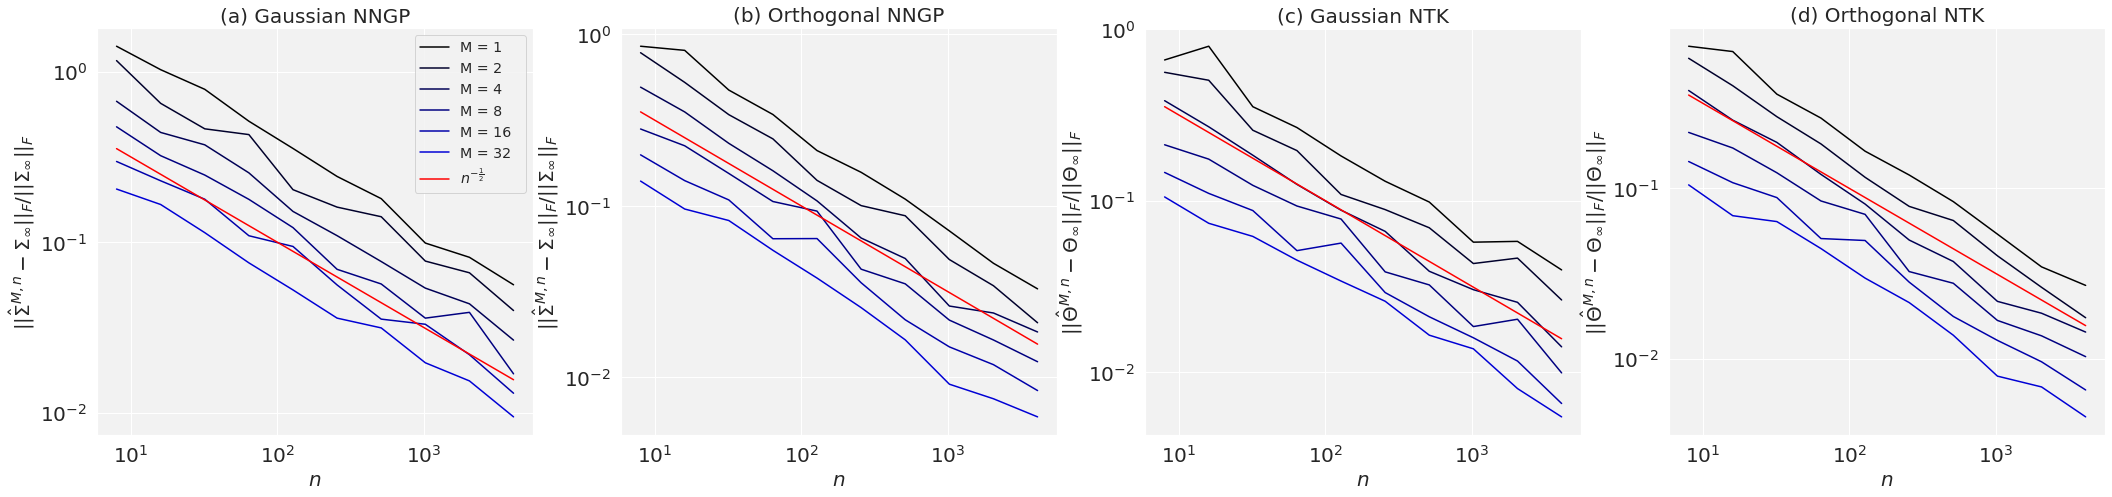

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

plt.figure(figsize=(36, 7.5))
gs = plt.GridSpec(1, 4)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

xis = numpy.arange(0,number_width)

plt.subplot(gs[0, 0])

norm_gau_nngp = numpy.zeros((number_width, number_sample))
for ns in range(0,number_sample):
    for nw in range(0,number_width):
        norm_gau_nngp[nw,ns] =  (numpy.linalg.norm(nngp[nw]-nngp_gau_mc[nw,ns])/numpy.linalg.norm(nngp[nw]))
    plt.loglog(2**(xis+3),norm_gau_nngp[:,ns],color=[0,0,ns/6],label=r'M = %d  ' %(2**ns))
    

plt.loglog(2**(xis+3),  (2.0**(xis+3))**(-0.5),color = 'red', label= r'$n^{-\frac{1}{2}}$')  

plt.xlabel('$n$',fontsize=20);  plt.ylabel('$||\hat \Sigma^{M,n} - \Sigma_\infty||_F/||\Sigma_\infty||_F$',fontsize=20) 
plt.title('(a) Gaussian NNGP',fontsize=20); plt.legend()


plt.subplot(gs[0, 1])  

norm_ort_nngp = numpy.zeros((number_width, number_sample))
for ns in range(0,number_sample):
    for nw in range(0,number_width):
        norm_ort_nngp[nw,ns] =  (numpy.linalg.norm(nngp[nw]-nngp_ort_mc[nw,ns])/numpy.linalg.norm(nngp[nw]))
    plt.loglog(2**(xis+3),norm_ort_nngp[:,ns],color=[0,0,ns/6],label=r'M = %d  ' %(2**ns))
    

plt.loglog(2**(xis+3),  (2.0**(xis+3))**(-0.5),color = 'red', label= r'$n^{-\frac{1}{1}}$')  

plt.xlabel('$n$',fontsize=20);  plt.ylabel('$||\hat \Sigma^{M,n} - \Sigma_\infty||_F/||\Sigma_\infty||_F$',fontsize=20) 
plt.title('(b) Orthogonal NNGP',fontsize=20); 



plt.subplot(gs[0, 2]) 

norm_gau_ntk = numpy.zeros((number_width, number_sample))
for ns in range(0,number_sample):
    for nw in range(0,number_width):
        norm_gau_ntk[nw,ns] =  (numpy.linalg.norm(ntk[nw]-ntk_gau_mc[nw,ns])/numpy.linalg.norm(ntk[nw]))
    plt.loglog(2**(xis+3),norm_gau_ntk[:,ns],color=[0,0,ns/6],label=r'M = %d  ' %(2**ns))
    
plt.loglog(2**(xis+3),  (2.0**(xis+3))**(-0.5),color = 'red', label= r'$N^{-\frac{1}{1}}$')  

plt.xlabel('$n$',fontsize=20);  plt.ylabel('$||\hat \Theta^{M,n} - \Theta_\infty||_F/||\Theta_\infty||_F$',fontsize=20) 
plt.title('(c) Gaussian NTK',fontsize=20); 


plt.subplot(gs[0, 3])  

norm_ort_ntk = numpy.zeros((number_width, number_sample))
for ns in range(0,number_sample):
    for nw in range(0,number_width):
        norm_ort_ntk[nw,ns] =  (numpy.linalg.norm(ntk[nw]-ntk_ort_mc[nw,ns])/numpy.linalg.norm(ntk[nw]))
    plt.loglog(2**(xis+3),norm_ort_ntk[:,ns],color=[0,0,ns/6],label=r'M = %d  ' %(2**ns))
    
plt.loglog(2**(xis+3),  (2.0**(xis+3))**(-0.5),color = 'red', label= r'$N^{-\frac{1}{1}}$')  

plt.xlabel('$n$',fontsize=20);  plt.ylabel('$||\hat \Theta^{M,n} - \Theta_\infty||_F/||\Theta_\infty||_F$',fontsize=20) 
plt.title('(d) Orthogonal NTK',fontsize=20); 


plt.savefig(  "fig1_convergence.pdf" ,  bbox_inches='tight')
